# Dataset 

In [1]:
import os 
import pandas as pd 

def create_set(dataset_dir):
    data = [] 

    for folder in os.scandir(dataset_dir):
        for file in os.scandir(folder.path):
            data.append({
                "path": file.path, 
                "class": folder.name
            })

    return pd.DataFrame(data, index=None)

In [2]:
train = create_set("../data/fixed_ayd/train")
test = create_set("../data/fixed_ayd/test") 
# val = create_set("../data/fixed_ayd/val")

# Data Generators 

In [131]:
import tensorflow as tf 

IMG_SIZE = (224, 224) 
TRAIN_DIR = "../data/fixed_ayd/train/"
VAL_DIR = "../data/fixed_ayd/val/"
TEST_DIR = "../data/fixed_ayd/test/"

train_data = tf.keras.preprocessing.image_dataset_from_directory(TRAIN_DIR,
                                                                label_mode='categorical', 
                                                                image_size=IMG_SIZE, 
                                                                shuffle=True) 

test_data = tf.keras.preprocessing.image_dataset_from_directory(TEST_DIR, 
                                                                label_mode='categorical', 
                                                                image_size=IMG_SIZE, 
                                                                shuffle=True) 

val_data = tf.keras.preprocessing.image_dataset_from_directory(VAL_DIR, 
                                                                label_mode='categorical', 
                                                                image_size=IMG_SIZE, 
                                                                shuffle=True) 

Found 17132 files belonging to 17 classes.
Found 5711 files belonging to 17 classes.
Found 5710 files belonging to 17 classes.


# Models:

## 1.Very Base Model With EfficientNet BO 

In [5]:
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False 

In [6]:
from tensorflow.keras import layers

inputs = layers.Input(shape=(224, 224, 3), name='input_layer')
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D(name='global_average_pooling')(x)
outputs = layers.Dense(len(train["class"].unique()), activation='softmax', name='output')(x)
model_1 = tf.keras.Model(inputs, outputs)

In [7]:
checkpoint_path = './checkpoints/model_1/checkpoint-{epoch:01d}.ckpt'
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights_only=True, 
                                                         monitor='val_loss', 
                                                         save_best_only=False) 

In [8]:
model_1.compile(loss='categorical_crossentropy', 
              optimizer=tf.keras.optimizers.Adam(), 
              metrics=[
                  tf.keras.metrics.Recall(), 
                  tf.keras.metrics.Precision()]) 

In [9]:
model_1_history = model_1.fit(train_data, 
                            epochs=10, 
                            validation_data=val_data, 
                            validation_steps= len(val_data), 
                            callbacks=[checkpoint_callback]) 

Epoch 1/10
536/536 [==============================] - 941s 2s/step - loss: 1.4402 - recall: 0.3037 - precision: 0.7976 - val_loss: 1.1914 - val_recall: 0.4347 - val_precision: 0.8058
Epoch 2/10
536/536 [==============================] - 934s 2s/step - loss: 1.1111 - recall: 0.4675 - precision: 0.8027 - val_loss: 1.0987 - val_recall: 0.4986 - val_precision: 0.8033
Epoch 3/10
536/536 [==============================] - 969s 2s/step - loss: 1.0185 - recall: 0.5168 - precision: 0.8120 - val_loss: 1.0658 - val_recall: 0.5208 - val_precision: 0.8027
Epoch 4/10
536/536 [==============================] - 972s 2s/step - loss: 0.9633 - recall: 0.5445 - precision: 0.8176 - val_loss: 1.0370 - val_recall: 0.5378 - val_precision: 0.7966
Epoch 5/10
536/536 [==============================] - 955s 2s/step - loss: 0.9212 - recall: 0.5657 - precision: 0.8225 - val_loss: 1.0164 - val_recall: 0.5569 - val_precision: 0.7996
Epoch 6/10
536/536 [==============================] - 932s 2s/step - loss: 0.8885 - r

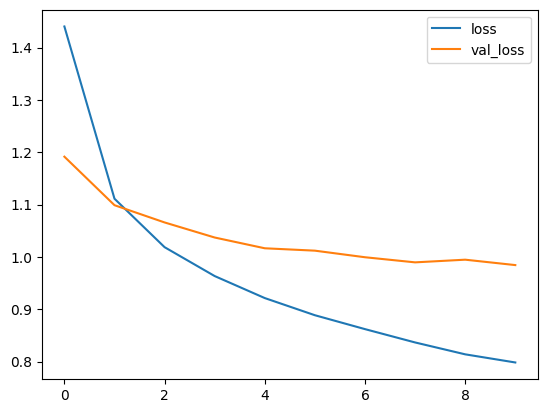

In [13]:
import matplotlib.pyplot as plt 

pd.DataFrame(model_1_history.history)[["loss", "val_loss"]].plot() 
plt.show()

In [15]:
hist = pd.DataFrame(model_1_history.history)


def calculate_f1(precision, recall):
    f1 = 2 * (precision * recall) / (precision + recall)
    return f1

hist['f1_score'] = hist.apply(lambda row: calculate_f1(row["precision"], row["recall"]), axis=1)
hist['val_f1_score'] = hist.apply(lambda row: calculate_f1(row["val_precision"], row["val_recall"]), axis=1)
hist.head() 

,loss,recall,precision,val_loss,val_recall,val_precision,f1_score,val_f1_score
0,1.440235,0.303701,0.797639,1.191440,0.434676,0.805844,0.439907,0.564733
1,1.111084,0.467488,0.802746,1.098726,0.498599,0.803330,0.590874,0.615302
2,1.018488,0.516811,0.811996,1.065768,0.520841,0.802699,0.631617,0.631758
3,0.963296,0.544537,0.817616,1.036968,0.537828,0.796628,0.653703,0.642133
4,0.921243,0.565725,0.822471,1.016397,0.556918,0.799598,0.670356,0.656550


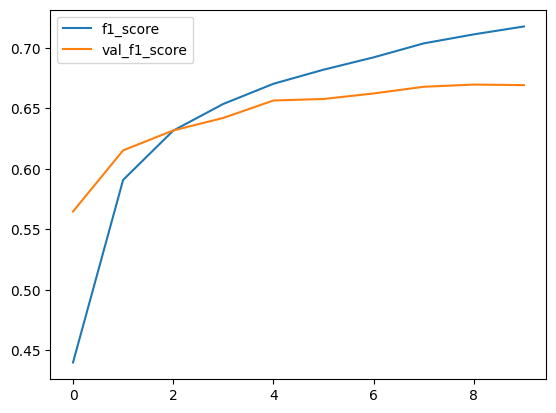

In [16]:
hist[["f1_score", "val_f1_score"]].plot() 
plt.show()

### Model 1 fine tune 

In [17]:
base_model.trainable = True  

for layer in base_model.layers[:-5]:
    layer.trainable = False 

model_1.compile(loss='categorical_crossentropy', 
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), 
              metrics=[
                  tf.keras.metrics.Recall(), 
                  tf.keras.metrics.Precision()]) 

In [18]:
model_1_history_fine = model_1.fit(train_data, 
                            epochs=30, 
                            initial_epoch=10,
                            validation_data=val_data, 
                            validation_steps= len(val_data), 
                            callbacks=[checkpoint_callback]) 

Epoch 11/30
536/536 [==============================] - 991s 2s/step - loss: 0.7746 - recall_1: 0.6468 - precision_1: 0.8330 - val_loss: 0.9630 - val_recall_1: 0.6156 - val_precision_1: 0.7775
Epoch 12/30
536/536 [==============================] - 977s 2s/step - loss: 0.6983 - recall_1: 0.6821 - precision_1: 0.8521 - val_loss: 0.9387 - val_recall_1: 0.6187 - val_precision_1: 0.7816
Epoch 13/30
536/536 [==============================] - 979s 2s/step - loss: 0.6428 - recall_1: 0.7083 - precision_1: 0.8639 - val_loss: 0.9278 - val_recall_1: 0.6306 - val_precision_1: 0.7880
Epoch 14/30
536/536 [==============================] - 998s 2s/step - loss: 0.5915 - recall_1: 0.7310 - precision_1: 0.8791 - val_loss: 0.9257 - val_recall_1: 0.6357 - val_precision_1: 0.7728
Epoch 15/30
536/536 [==============================] - 985s 2s/step - loss: 0.5520 - recall_1: 0.7490 - precision_1: 0.8876 - val_loss: 0.9249 - val_recall_1: 0.6370 - val_precision_1: 0.7770
Epoch 16/30
536/536 [===================

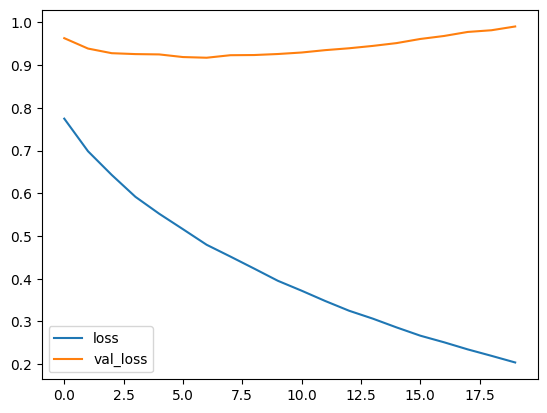

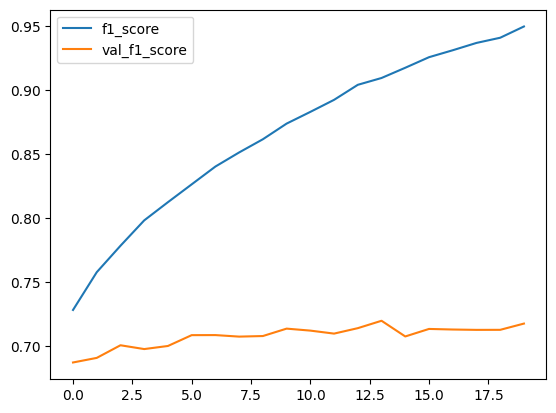

In [22]:
hist = pd.DataFrame(model_1_history_fine.history)
hist.columns = hist.columns.to_series().apply(lambda x: str(x).replace("_1", ""))

hist['f1_score'] = hist.apply(lambda row: calculate_f1(row["precision"], row["recall"]), axis=1)
hist['val_f1_score'] = hist.apply(lambda row: calculate_f1(row["val_precision"], row["val_recall"]), axis=1)
hist[["loss", "val_loss"]].plot()
plt.show() 
hist[["f1_score", "val_f1_score"]].plot() 
plt.show()

## Model 2: Efficient Net, L2 Reg for Output Layers 

In [39]:
from tensorflow.keras.callbacks import Callback
from tensorflow.keras import regularizers

class DynamicRegularization(Callback):
    def __init__(self, initial_strength, increase_rate):
        super(DynamicRegularization, self).__init__()
        self.initial_strength = initial_strength
        self.increase_rate = increase_rate

    def on_epoch_begin(self, epoch, logs=None):
        regularization_strength = self.initial_strength + (epoch * self.increase_rate)
        self.model.layers[-1].kernel_regularizer = regularizers.l2(regularization_strength)
        print("Regularization strength updated for epoch {}: {}".format(epoch, regularization_strength))


In [26]:
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False 

def get_regularization_strength(epoch):
    initial_strength = 0.01
    increase_rate = 0.1

    return initial_strength + (epoch * increase_rate)


inputs = layers.Input(shape=(224, 224, 3), name='input_layer')
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D(name='global_average_pooling')(x) 
outputs = layers.Dense(len(train["class"].unique()), activation='softmax', name='output')(x)
model_2 = tf.keras.Model(inputs, outputs)


checkpoint_path = './checkpoints/model_2_1/checkpoint-{epoch:01d}.ckpt'
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights_only=True, 
                                                         monitor='val_loss', 
                                                         save_best_only=False) 
model_2.compile(loss='categorical_crossentropy', 
              optimizer=tf.keras.optimizers.Adam(), 
              metrics=[
                  tf.keras.metrics.Recall(name="recall"), 
                  tf.keras.metrics.Precision(name="precision")]) 

dynamic_reg_callback = DynamicRegularization(initial_strength=0.70, increase_rate=0.1)

model_2_history = model_2.fit(train_data, 
                            epochs=10, 
                            validation_data=val_data, 
                            validation_steps= len(val_data), 
                            callbacks=[checkpoint_callback, dynamic_reg_callback]) 

Regularization strength updated for epoch 0: 0.7
Epoch 1/10
536/536 [==============================] - 996s 2s/step - loss: 1.4399 - recall: 0.3032 - precision: 0.7968 - val_loss: 1.1922 - val_recall: 0.4389 - val_precision: 0.8048
Regularization strength updated for epoch 1: 0.7999999999999999
Epoch 2/10
536/536 [==============================] - 1005s 2s/step - loss: 1.1111 - recall: 0.4682 - precision: 0.7996 - val_loss: 1.0964 - val_recall: 0.4967 - val_precision: 0.8025
Regularization strength updated for epoch 2: 0.8999999999999999
Epoch 3/10
536/536 [==============================] - 991s 2s/step - loss: 1.0196 - recall: 0.5149 - precision: 0.8123 - val_loss: 1.0533 - val_recall: 0.5257 - val_precision: 0.8035
Regularization strength updated for epoch 3: 1.0
Epoch 4/10
536/536 [==============================] - 996s 2s/step - loss: 0.9625 - recall: 0.5461 - precision: 0.8196 - val_loss: 1.0332 - val_recall: 0.5380 - val_precision: 0.8040
Regularization strength updated for epoch

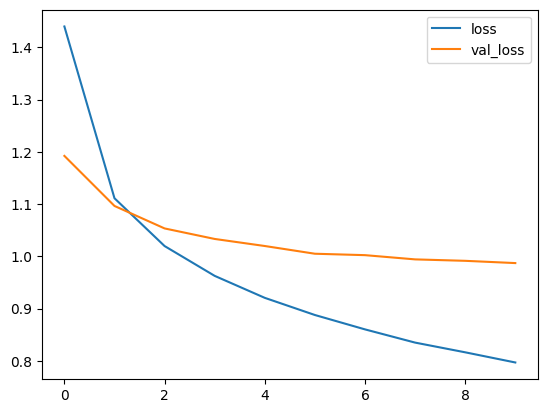

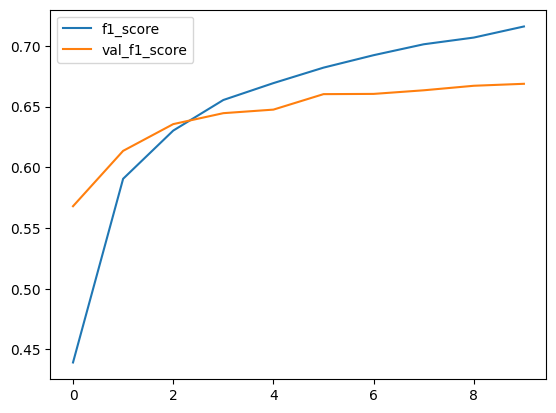

In [28]:
hist = pd.DataFrame(model_2_history.history)
hist.columns = hist.columns.to_series().apply(lambda x: str(x).replace("_1", ""))

hist['f1_score'] = hist.apply(lambda row: calculate_f1(row["precision"], row["recall"]), axis=1)
hist['val_f1_score'] = hist.apply(lambda row: calculate_f1(row["val_precision"], row["val_recall"]), axis=1)
hist[["loss", "val_loss"]].plot()
plt.show() 
hist[["f1_score", "val_f1_score"]].plot() 
plt.show()

### Model 2 fine tune 

In [43]:
base_model.trainable = True  

for layer in base_model.layers[:-5]:
    layer.trainable = False 

model_2.compile(loss='categorical_crossentropy', 
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), 
              metrics=[
                  tf.keras.metrics.Recall(name="recall"), 
                  tf.keras.metrics.Precision(name="precision")]) 



In [44]:
dynamic_reg_callback2 = DynamicRegularization(initial_strength=0.001, increase_rate=0.1)
model_2_history_fine = model_2.fit(train_data, 
                            epochs=30, 
                            initial_epoch=10,
                            validation_data=val_data, 
                            validation_steps= len(val_data), 
                            callbacks=[checkpoint_callback, dynamic_reg_callback2]) 

Regularization strength updated for epoch 10: 1.001
Epoch 11/30


536/536 [==============================] - 1186s 2s/step - loss: 0.7764 - recall: 0.6482 - precision: 0.8363 - val_loss: 0.9643 - val_recall: 0.6107 - val_precision: 0.7778
Regularization strength updated for epoch 11: 1.101
Epoch 12/30
536/536 [==============================] - 1178s 2s/step - loss: 0.6959 - recall: 0.6823 - precision: 0.8528 - val_loss: 0.9399 - val_recall: 0.6250 - val_precision: 0.7815
Regularization strength updated for epoch 12: 1.201
Epoch 13/30
536/536 [==============================] - 1222s 2s/step - loss: 0.6426 - recall: 0.7055 - precision: 0.8627 - val_loss: 0.9458 - val_recall: 0.6299 - val_precision: 0.7737
Regularization strength updated for epoch 13: 1.301
Epoch 14/30
536/536 [==============================] - 1221s 2s/step - loss: 0.5946 - recall: 0.7290 - precision: 0.8769 - val_loss: 0.9271 - val_recall: 0.6375 - val_precision: 0.7779
Regularization strength updated for epoch 14: 1.401
Epoch 15/30
536/536 [==============================] - 1196s 2s/

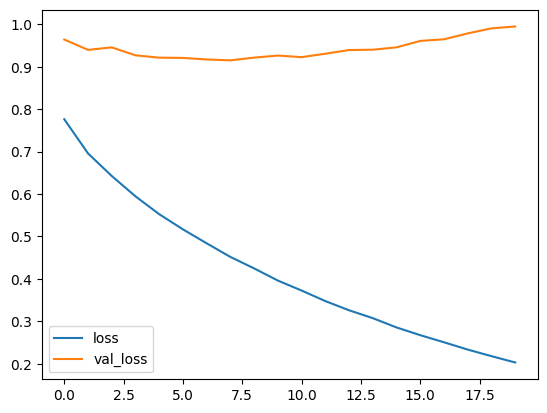

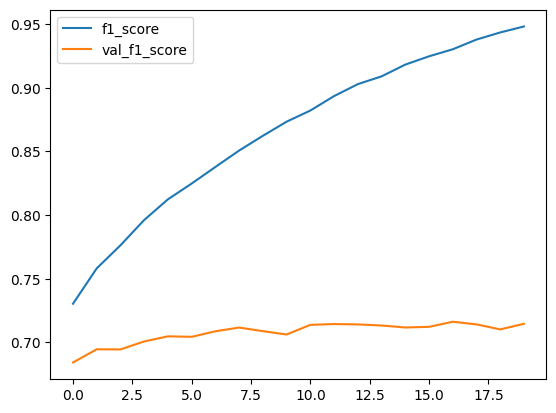

In [45]:
hist = pd.DataFrame(model_2_history_fine.history)
hist.columns = hist.columns.to_series().apply(lambda x: str(x).replace("_1", ""))

hist['f1_score'] = hist.apply(lambda row: calculate_f1(row["precision"], row["recall"]), axis=1)
hist['val_f1_score'] = hist.apply(lambda row: calculate_f1(row["val_precision"], row["val_recall"]), axis=1)
hist[["loss", "val_loss"]].plot()
plt.show() 
hist[["f1_score", "val_f1_score"]].plot() 
plt.show()

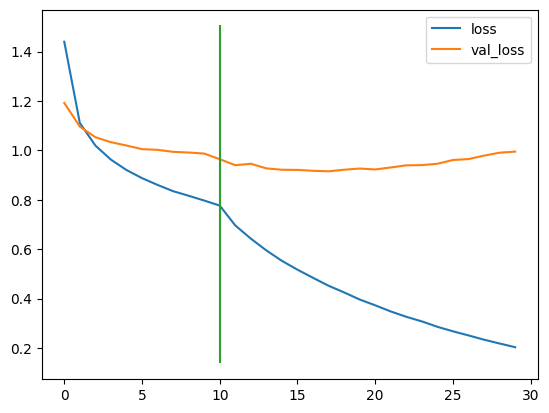

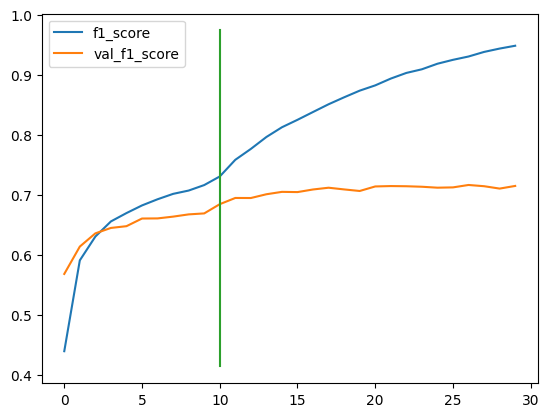

In [56]:
def paint_state(model_history, model_history_fine, fine_tune = 0):
    hist = pd.concat([
        pd.DataFrame(model_2_history.history),
        pd.DataFrame(model_2_history_fine.history)
    ]).reset_index(drop=True)

    hist.columns = hist.columns.to_series().apply(lambda x: str(x).replace("_1", ""))

    hist['f1_score'] = hist.apply(lambda row: calculate_f1(row["precision"], row["recall"]), axis=1)
    hist['val_f1_score'] = hist.apply(lambda row: calculate_f1(row["val_precision"], row["val_recall"]), axis=1)
    
    hist[["loss", "val_loss"]].plot()
    if fine_tune > 0:
        plt.plot([fine_tune, fine_tune],
                plt.ylim(), label='Start Fine Tuning')
    plt.show() 
    hist[["f1_score", "val_f1_score"]].plot() 
    if fine_tune > 0:
        plt.plot([fine_tune, fine_tune],
                plt.ylim(), label='Start Fine Tuning')
    plt.show()

paint_state(model_2_history, model_2_history_fine, fine_tune=10)

# Model 3: Ef Net B0 - Data Augmentation, L2 Regularization and Learning Rate Decay  

In [105]:
from tensorflow.keras import layers 
from tensorflow.keras.layers.experimental import preprocessing 
from tensorflow.keras.models import Sequential 

data_augmentation = Sequential([
    preprocessing.RandomFlip('horizontal'), 
    preprocessing.RandomRotation(0.2), 
    preprocessing.RandomHeight(0.2), 
    preprocessing.RandomWidth(0.2), 
    preprocessing.RandomZoom(0.2), 
  # preprocessing.Rescaling(1./255) 
], name='data_augmentation') 

In [62]:
from tensorflow.keras.callbacks import LearningRateScheduler

base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = True  

for layer in base_model.layers[:-5]:
    layer.trainable = False 

inputs = layers.Input(shape=(224, 224, 3), name='input_layer')
x = data_augmentation(inputs)
x = base_model(x)
x = layers.GlobalAveragePooling2D(name='global_average_pooling')(x) 
kernel_regularizer = tf.keras.regularizers.l2(l2=0.1)
outputs = layers.Dense(len(train["class"].unique()), kernel_regularizer = kernel_regularizer, activation='softmax', name='output')(x)
model_3 = tf.keras.Model(inputs, outputs)


checkpoint_path = './checkpoints/model_3/checkpoint-{epoch:01d}.ckpt'
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights_only=True, 
                                                         monitor='val_loss', 
                                                         save_best_only=False) 
model_3.compile(loss='categorical_crossentropy', 
              optimizer=tf.keras.optimizers.Adam(), 
              metrics=[
                  tf.keras.metrics.Recall(name="recall"), 
                  tf.keras.metrics.Precision(name="precision")]) 


def learning_rate_schedule(epoch, lr):
    if epoch < 10:
        return lr 
    else:
        return lr * tf.math.exp(-0.1)  

lr_scheduler = LearningRateScheduler(learning_rate_schedule)

model_3_history = model_3.fit(train_data, 
                            epochs=50, 
                            validation_data=val_data, 
                            validation_steps= len(val_data), 
                            callbacks=[checkpoint_callback, lr_scheduler]) 

Epoch 1/50
536/536 [==============================] - 1319s 2s/step - loss: 1.8486 - recall: 0.3150 - precision: 0.7655 - val_loss: 1.4389 - val_recall: 0.4173 - val_precision: 0.7353 - lr: 0.0010
Epoch 2/50
536/536 [==============================] - 1286s 2s/step - loss: 1.4724 - recall: 0.3970 - precision: 0.7607 - val_loss: 1.3770 - val_recall: 0.4602 - val_precision: 0.7637 - lr: 0.0010
Epoch 3/50
536/536 [==============================] - 1250s 2s/step - loss: 1.4083 - recall: 0.4255 - precision: 0.7682 - val_loss: 1.2969 - val_recall: 0.4886 - val_precision: 0.7893 - lr: 0.0010
Epoch 4/50
536/536 [==============================] - 1242s 2s/step - loss: 1.3791 - recall: 0.4398 - precision: 0.7697 - val_loss: 1.3623 - val_recall: 0.4490 - val_precision: 0.7515 - lr: 0.0010
Epoch 5/50
536/536 [==============================] - 1280s 2s/step - loss: 1.3471 - recall: 0.4569 - precision: 0.7770 - val_loss: 1.3497 - val_recall: 0.4986 - val_precision: 0.7311 - lr: 0.0010
Epoch 6/50
536/

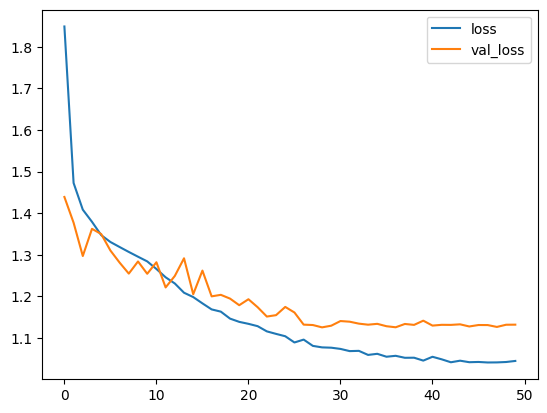

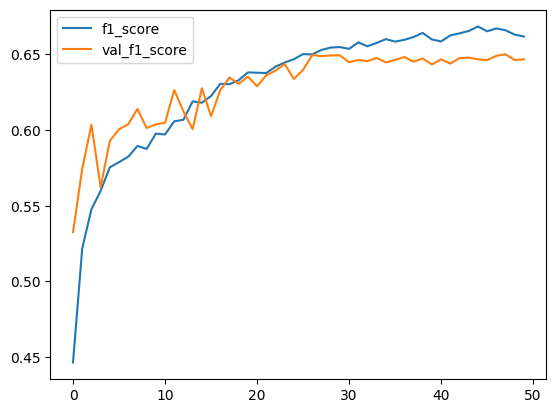

In [65]:
hist = pd.DataFrame(model_3_history.history)
hist.columns = hist.columns.to_series().apply(lambda x: str(x).replace("_1", ""))
hist['f1_score'] = hist.apply(lambda row: calculate_f1(row["precision"], row["recall"]), axis=1)
hist['val_f1_score'] = hist.apply(lambda row: calculate_f1(row["val_precision"], row["val_recall"]), axis=1)
hist[["loss", "val_loss"]].plot()
plt.show() 
hist[["f1_score", "val_f1_score"]].plot()
plt.show()

In [67]:
base_model.trainable = True  

for layer in base_model.layers[:-10]:
    layer.trainable = False 

model_3.compile(loss='categorical_crossentropy', 
              optimizer=tf.keras.optimizers.Adam(), 
              metrics=[
                  tf.keras.metrics.Recall(name="recall"), 
                  tf.keras.metrics.Precision(name="precision")]) 


model_3_history = model_3.fit(train_data, 
                            epochs=100,
                            initial_epoch=50, 
                            validation_data=val_data, 
                            validation_steps= len(val_data), 
                            callbacks=[checkpoint_callback, lr_scheduler]) 

Epoch 51/100
536/536 [==============================] - 1321s 2s/step - loss: 1.1927 - recall: 0.5201 - precision: 0.7835 - val_loss: 1.2400 - val_recall: 0.5194 - val_precision: 0.7714 - lr: 9.0484e-04
Epoch 52/100
536/536 [==============================] - 1281s 2s/step - loss: 1.1836 - recall: 0.5255 - precision: 0.7874 - val_loss: 1.3177 - val_recall: 0.4890 - val_precision: 0.7469 - lr: 8.1873e-04
Epoch 53/100
536/536 [==============================] - 1311s 2s/step - loss: 1.1519 - recall: 0.5336 - precision: 0.8009 - val_loss: 1.3210 - val_recall: 0.5177 - val_precision: 0.7203 - lr: 7.4082e-04
Epoch 54/100
536/536 [==============================] - 1303s 2s/step - loss: 1.1304 - recall: 0.5380 - precision: 0.7985 - val_loss: 1.2045 - val_recall: 0.5405 - val_precision: 0.7769 - lr: 6.7032e-04
Epoch 55/100
536/536 [==============================] - 1297s 2s/step - loss: 1.1007 - recall: 0.5527 - precision: 0.8031 - val_loss: 1.2037 - val_recall: 0.5469 - val_precision: 0.7666 - 

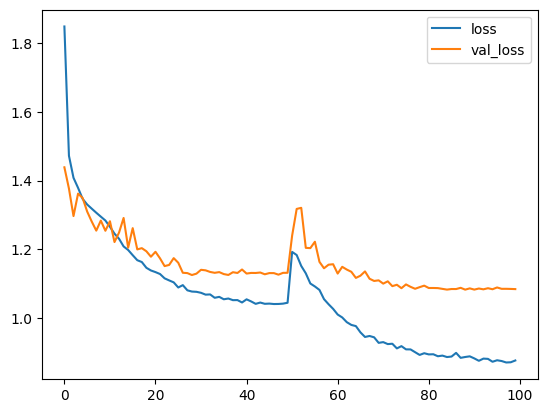

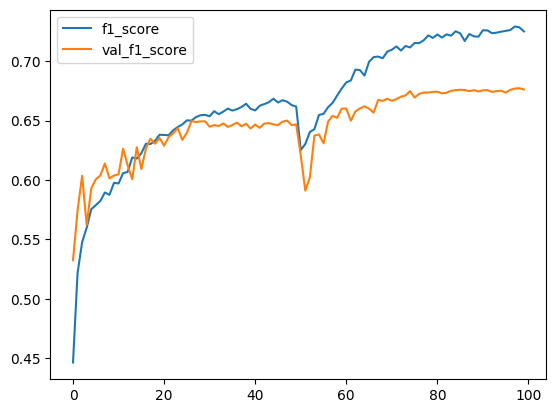

In [71]:
hist2 = pd.concat([hist, pd.DataFrame(model_3_history.history)]).reset_index(drop=True)
hist2.columns = hist2.columns.to_series().apply(lambda x: str(x).replace("_1", ""))
hist2['f1_score'] = hist2.apply(lambda row: calculate_f1(row["precision"], row["recall"]), axis=1)
hist2['val_f1_score'] = hist2.apply(lambda row: calculate_f1(row["val_precision"], row["val_recall"]), axis=1)
hist2[["loss", "val_loss"]].plot()
plt.show() 
hist2[["f1_score", "val_f1_score"]].plot()
plt.show()

# Model 4: Ef Net B0 - Extra Layer With Drop-Out 

In [123]:
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False 


inputs = layers.Input(shape=(224, 224, 3), name='input_layer')
x = base_model(inputs)
x = layers.GlobalAveragePooling2D(name='global_average_pooling')(x) 
x = layers.BatchNormalization()(x) 
x = layers.Dropout(0.4, name="after_base_dropout")(x) 
x = layers.Dense(32, activation='relu', name='custom_dense')(x) 
x = layers.Dropout(0.3, name="after_custom_dense_dropout")(x) 
outputs = layers.Dense(len(train["class"].unique()), activation='softmax', name='output')(x)
model_4 = tf.keras.Model(inputs, outputs)


checkpoint_path = './checkpoints/model_4/checkpoint-{epoch:01d}.ckpt'
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights_only=True, 
                                                         monitor='val_loss', 
                                                         save_best_only=False) 
model_4.compile(loss='categorical_crossentropy', 
              optimizer=tf.keras.optimizers.Adam(learning_rate=1e-2), 
              metrics=[
                  tf.keras.metrics.Recall(name="recall"), 
                  tf.keras.metrics.Precision(name="precision")]) 

model_4_history = model_4.fit(train_data, 
                                epochs=50, 
                                validation_data=val_data, 
                                validation_steps= len(val_data), 
                                callbacks=[checkpoint_callback]) 

Epoch 1/50
536/536 [==============================] - 2060s 4s/step - loss: 1.8978 - recall: 0.2687 - precision: 0.6420 - val_loss: 1.4098 - val_recall: 0.3629 - val_precision: 0.8129
Epoch 2/50
536/536 [==============================] - 2060s 4s/step - loss: 1.7130 - recall: 0.3161 - precision: 0.6929 - val_loss: 1.3746 - val_recall: 0.3778 - val_precision: 0.8255
Epoch 3/50
536/536 [==============================] - 1472s 3s/step - loss: 1.6794 - recall: 0.3242 - precision: 0.6876 - val_loss: 1.3509 - val_recall: 0.4028 - val_precision: 0.7970
Epoch 4/50
536/536 [==============================] - 1217s 2s/step - loss: 1.6672 - recall: 0.3294 - precision: 0.7050 - val_loss: 1.3405 - val_recall: 0.4005 - val_precision: 0.7827
Epoch 5/50
536/536 [==============================] - 1192s 2s/step - loss: 1.6554 - recall: 0.3336 - precision: 0.6944 - val_loss: 1.3262 - val_recall: 0.4382 - val_precision: 0.8004
Epoch 6/50
536/536 [==============================] - 1202s 2s/step - loss: 1.64

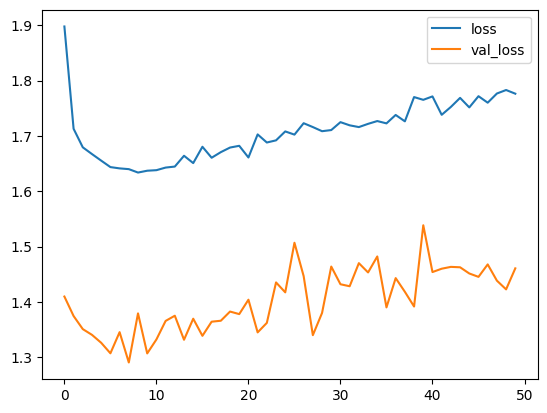

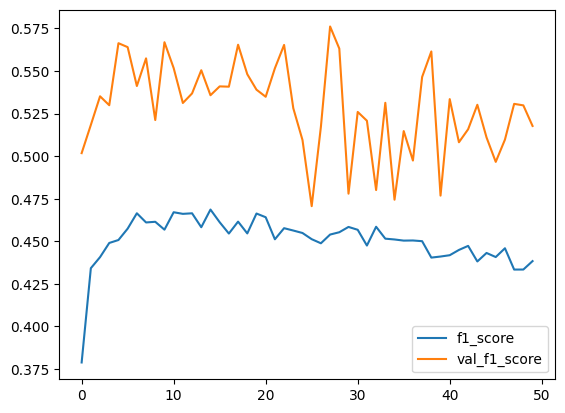

In [124]:
hist = pd.DataFrame(model_4_history.history).reset_index(drop=True)
hist.columns = hist.columns.to_series().apply(lambda x: str(x).replace("_1", ""))
hist['f1_score'] = hist.apply(lambda row: calculate_f1(row["precision"], row["recall"]), axis=1)
hist['val_f1_score'] = hist.apply(lambda row: calculate_f1(row["val_precision"], row["val_recall"]), axis=1)
hist[["loss", "val_loss"]].plot()
plt.show() 
hist[["f1_score", "val_f1_score"]].plot()
plt.show()

# Model 4: Ef Net B0 - Extra Layer and Data augmentation 

In [125]:
data_augmentation = Sequential([
    preprocessing.RandomFlip('horizontal'), 
    preprocessing.RandomRotation(0.2), 
    preprocessing.RandomHeight(0.2), 
    preprocessing.RandomWidth(0.2), 
    preprocessing.RandomZoom(0.2), 
  # preprocessing.Rescaling(1./255) 
], name='data_augmentation') 

In [126]:
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False 


inputs = layers.Input(shape=(224, 224, 3), name='input_layer')
x = data_augmentation(inputs)
x = base_model(x)
x = layers.GlobalAveragePooling2D(name='global_average_pooling')(x) 
x = layers.BatchNormalization()(x) 
x = layers.Dropout(0.3, name="after_base_dropout")(x) 
x = layers.Dense(32, activation='relu', name='custom_dense')(x) 
x = layers.Dropout(0.3, name="after_custom_dense_dropout")(x) 
outputs = layers.Dense(len(train["class"].unique()), activation='softmax', name='output')(x)
model_5 = tf.keras.Model(inputs, outputs)


checkpoint_path = './checkpoints/model_5/checkpoint-{epoch:01d}.ckpt'
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights_only=True, 
                                                         monitor='val_loss', 
                                                         save_best_only=False) 
model_5.compile(loss='categorical_crossentropy', 
              optimizer=tf.keras.optimizers.Adam(learning_rate=1e-2), 
              metrics=[
                  tf.keras.metrics.Recall(name="recall"), 
                  tf.keras.metrics.Precision(name="precision")]) 

model_5_history = model_5.fit(train_data, 
                                epochs=50, 
                                validation_data=val_data, 
                                validation_steps= len(val_data), 
                                callbacks=[checkpoint_callback]) 

Epoch 1/50
536/536 [==============================] - 2135s 4s/step - loss: 2.0702 - recall: 0.2038 - precision: 0.6218 - val_loss: 1.6840 - val_recall: 0.2236 - val_precision: 0.7529
Epoch 2/50
536/536 [==============================] - 2075s 4s/step - loss: 1.8821 - recall: 0.2427 - precision: 0.6661 - val_loss: 1.5721 - val_recall: 0.2865 - val_precision: 0.8250
Epoch 3/50
536/536 [==============================] - 2058s 4s/step - loss: 1.8344 - recall: 0.2565 - precision: 0.6735 - val_loss: 1.6470 - val_recall: 0.2713 - val_precision: 0.7657
Epoch 4/50
536/536 [==============================] - 2057s 4s/step - loss: 1.8375 - recall: 0.2611 - precision: 0.6763 - val_loss: 1.6210 - val_recall: 0.2825 - val_precision: 0.7800
Epoch 5/50
536/536 [==============================] - 2131s 4s/step - loss: 1.8249 - recall: 0.2652 - precision: 0.6774 - val_loss: 1.5608 - val_recall: 0.2753 - val_precision: 0.8078
Epoch 6/50
536/536 [==============================] - 2043s 4s/step - loss: 1.80

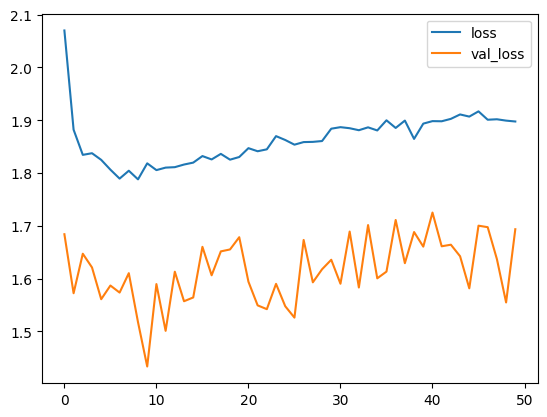

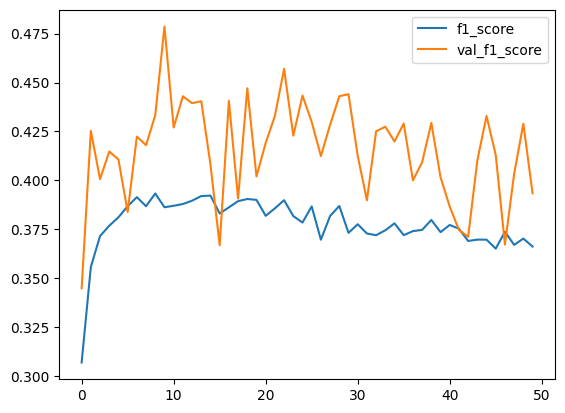

In [127]:
hist = pd.DataFrame(model_5_history.history).reset_index(drop=True)
hist.columns = hist.columns.to_series().apply(lambda x: str(x).replace("_1", ""))
hist['f1_score'] = hist.apply(lambda row: calculate_f1(row["precision"], row["recall"]), axis=1)
hist['val_f1_score'] = hist.apply(lambda row: calculate_f1(row["val_precision"], row["val_recall"]), axis=1)
hist[["loss", "val_loss"]].plot()
plt.show() 
hist[["f1_score", "val_f1_score"]].plot()
plt.show()

# Model 5.b: Ef Net B0 - Extra Layer and Data augmentation (Mini batch size 64)

In [130]:
train_data64 = tf.keras.preprocessing.image_dataset_from_directory(TRAIN_DIR,
                                                                label_mode='categorical', 
                                                                image_size=IMG_SIZE, 
                                                                shuffle=True,
                                                                batch_size=64
                                                                ) 

test_data64 = tf.keras.preprocessing.image_dataset_from_directory(TEST_DIR, 
                                                                label_mode='categorical', 
                                                                image_size=IMG_SIZE, 
                                                                shuffle=True,
                                                                batch_size=64) 

val_data64 = tf.keras.preprocessing.image_dataset_from_directory(VAL_DIR, 
                                                                label_mode='categorical', 
                                                                image_size=IMG_SIZE, 
                                                                shuffle=True, 
                                                                batch_size=64) 

Found 17132 files belonging to 17 classes.
Found 5711 files belonging to 17 classes.
Found 5710 files belonging to 17 classes.


In [141]:
data_augmentation = Sequential([
    preprocessing.RandomFlip('horizontal'), 
    preprocessing.RandomRotation(0.2), 
    preprocessing.RandomHeight(0.2), 
    preprocessing.RandomWidth(0.2), 
    preprocessing.RandomZoom(0.2), 
  # preprocessing.Rescaling(1./255) 
], name='data_augmentation') 

In [142]:
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False 


inputs = layers.Input(shape=(224, 224, 3), name='input_layer')
x = data_augmentation(inputs)
x = base_model(x)
x = layers.GlobalAveragePooling2D(name='global_average_pooling')(x) 
x = layers.BatchNormalization()(x) 
x = layers.Dropout(0.3, name="after_base_dropout")(x) 
x = layers.Dense(32, activation='relu', name='custom_dense')(x) 
x = layers.Dropout(0.3, name="after_custom_dense_dropout")(x) 
outputs = layers.Dense(len(train["class"].unique()), activation='softmax', name='output')(x)
model_5b = tf.keras.Model(inputs, outputs)


checkpoint_path = './checkpoints/model_5b/checkpoint-{epoch:01d}.ckpt'
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights_only=True, 
                                                         monitor='val_loss', 
                                                         save_best_only=False) 
model_5b.compile(loss='categorical_crossentropy', 
              optimizer=tf.keras.optimizers.Adam(learning_rate=1e-2), 
              metrics=[
                  tf.keras.metrics.Recall(name="recall"), 
                  tf.keras.metrics.Precision(name="precision")]) 

model_5b_history = model_5b.fit(train_data64, 
                                epochs=50, 
                                validation_data=val_data64, 
                                validation_steps= len(val_data64), 
                                callbacks=[checkpoint_callback]) 

Epoch 1/50
268/268 [==============================] - 2014s 7s/step - loss: 1.9782 - recall: 0.2327 - precision: 0.6280 - val_loss: 1.7805 - val_recall: 0.1138 - val_precision: 0.8621
Epoch 2/50
268/268 [==============================] - 1976s 7s/step - loss: 1.7359 - recall: 0.2735 - precision: 0.6797 - val_loss: 1.4021 - val_recall: 0.3194 - val_precision: 0.8231
Epoch 3/50
268/268 [==============================] - 1947s 7s/step - loss: 1.6809 - recall: 0.2935 - precision: 0.6843 - val_loss: 1.4605 - val_recall: 0.3168 - val_precision: 0.7917
Epoch 4/50
268/268 [==============================] - 1797s 7s/step - loss: 1.6487 - recall: 0.3108 - precision: 0.6987 - val_loss: 1.3946 - val_recall: 0.3727 - val_precision: 0.7578
Epoch 5/50
268/268 [==============================] - 1807s 7s/step - loss: 1.6365 - recall: 0.3118 - precision: 0.7000 - val_loss: 1.3829 - val_recall: 0.3419 - val_precision: 0.7906
Epoch 6/50
268/268 [==============================] - 1666s 6s/step - loss: 1.63

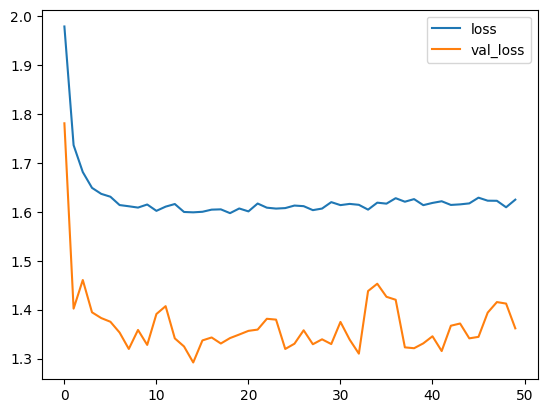

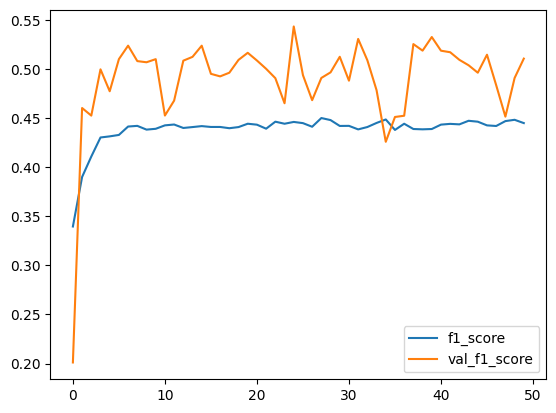

In [143]:
hist = pd.DataFrame(model_5b_history.history).reset_index(drop=True)
hist.columns = hist.columns.to_series().apply(lambda x: str(x).replace("_1", ""))
hist['f1_score'] = hist.apply(lambda row: calculate_f1(row["precision"], row["recall"]), axis=1)
hist['val_f1_score'] = hist.apply(lambda row: calculate_f1(row["val_precision"], row["val_recall"]), axis=1)
hist[["loss", "val_loss"]].plot()
plt.show() 
hist[["f1_score", "val_f1_score"]].plot()
plt.show()

In [146]:
model_5b.layers[2].trainable = False 

for layer in model_5b.layers[2].layers[-15:]:
    if not isinstance(layer, layers.BatchNormalization):
        layer.trainable = True

model_5b.compile(loss='categorical_crossentropy', 
              optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), 
              metrics=[
                  tf.keras.metrics.Recall(name="recall"), 
                  tf.keras.metrics.Precision(name="precision")]) 

In [148]:
sum(np.array([layer.trainable for layer in model_5b.layers[2].layers]).astype("int")), len(model_5b.layers[2].layers)

(11, 238)

In [150]:
model_5b_history_fine = model_5b.fit(train_data64, 
                                epochs=100, 
                                initial_epoch=50,
                                validation_data=val_data64, 
                                validation_steps= len(val_data64), 
                                callbacks=[checkpoint_callback]) 

Epoch 51/100
268/268 [==============================] - 2039s 8s/step - loss: 1.5438 - recall: 0.3409 - precision: 0.7241 - val_loss: 1.3021 - val_recall: 0.3965 - val_precision: 0.8266
Epoch 52/100
268/268 [==============================] - 2002s 7s/step - loss: 1.5147 - recall: 0.3506 - precision: 0.7377 - val_loss: 1.2845 - val_recall: 0.4032 - val_precision: 0.8218
Epoch 53/100
268/268 [==============================] - 2004s 7s/step - loss: 1.4970 - recall: 0.3528 - precision: 0.7345 - val_loss: 1.2748 - val_recall: 0.4047 - val_precision: 0.8239
Epoch 54/100
268/268 [==============================] - 2043s 8s/step - loss: 1.4889 - recall: 0.3607 - precision: 0.7448 - val_loss: 1.2638 - val_recall: 0.4131 - val_precision: 0.8240
Epoch 55/100
268/268 [==============================] - 2014s 8s/step - loss: 1.4847 - recall: 0.3608 - precision: 0.7429 - val_loss: 1.2616 - val_recall: 0.4093 - val_precision: 0.8235
Epoch 56/100
268/268 [==============================] - 2004s 7s/step 

In [152]:
hits_prev = hist.copy() 

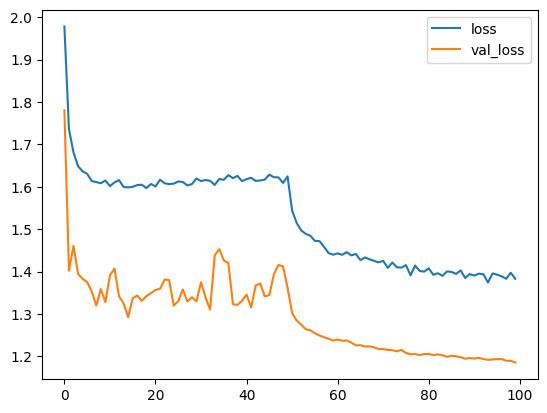

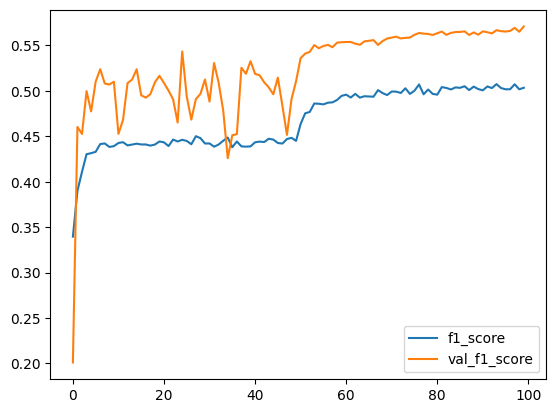

In [155]:
hist = pd.concat([hits_prev, pd.DataFrame(model_5b_history_fine.history)]).reset_index(drop=True)
hist.columns = hist.columns.to_series().apply(lambda x: str(x).replace("_1", ""))
hist['f1_score'] = hist.apply(lambda row: calculate_f1(row["precision"], row["recall"]), axis=1)
hist['val_f1_score'] = hist.apply(lambda row: calculate_f1(row["val_precision"], row["val_recall"]), axis=1)
hist[["loss", "val_loss"]].plot()
plt.show() 
hist[["f1_score", "val_f1_score"]].plot()
plt.show()

# Model 6: Mini-Batch 64, Data Augmentation, Drop-Out 

In [163]:
data_augmentation = Sequential([
    preprocessing.RandomFlip('horizontal'), 
    preprocessing.RandomRotation(0.2), 
    preprocessing.RandomHeight(0.2), 
    preprocessing.RandomWidth(0.2), 
    preprocessing.RandomZoom(0.2), 
  # preprocessing.Rescaling(1./255) 
], name='data_augmentation') 

In [164]:
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False 


inputs = layers.Input(shape=(224, 224, 3), name='input_layer')
x = data_augmentation(inputs)
x = base_model(x)
x = layers.GlobalAveragePooling2D(name='global_average_pooling')(x) 
x = layers.BatchNormalization()(x) 
x = layers.Dropout(0.1, name="after_base_dropout")(x) 
x = layers.Dense(32, activation='relu', name='custom_dense')(x) 
x = layers.Dropout(0.2, name="after_custom_dense_dropout")(x) 
outputs = layers.Dense(len(train["class"].unique()), activation='softmax', name='output')(x)
model_6 = tf.keras.Model(inputs, outputs)


checkpoint_path = './checkpoints/model_6/checkpoint-{epoch:01d}.ckpt'
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights_only=True, 
                                                         monitor='val_loss', 
                                                         save_best_only=False) 
model_6.compile(loss='categorical_crossentropy', 
              optimizer=tf.keras.optimizers.Adam(), 
              metrics=[
                  tf.keras.metrics.Recall(name="recall"), 
                  tf.keras.metrics.Precision(name="precision")]) 

model_6_history = model_6.fit(train_data64, 
                                epochs=10, 
                                validation_data=val_data64, 
                                validation_steps= len(val_data64), 
                                callbacks=[checkpoint_callback]) 

Epoch 1/10
268/268 [==============================] - 2195s 8s/step - loss: 1.9423 - recall: 0.2283 - precision: 0.6714 - val_loss: 1.5285 - val_recall: 0.2336 - val_precision: 0.8629
Epoch 2/10
268/268 [==============================] - 2121s 8s/step - loss: 1.5351 - recall: 0.3419 - precision: 0.7097 - val_loss: 1.3125 - val_recall: 0.3730 - val_precision: 0.8096
Epoch 3/10
268/268 [==============================] - 2166s 8s/step - loss: 1.4228 - recall: 0.3772 - precision: 0.7268 - val_loss: 1.2685 - val_recall: 0.4102 - val_precision: 0.7901
Epoch 4/10
268/268 [==============================] - 2104s 8s/step - loss: 1.3618 - recall: 0.3993 - precision: 0.7371 - val_loss: 1.2081 - val_recall: 0.4531 - val_precision: 0.7911
Epoch 5/10
268/268 [==============================] - 2111s 8s/step - loss: 1.3316 - recall: 0.4070 - precision: 0.7395 - val_loss: 1.1739 - val_recall: 0.4511 - val_precision: 0.8012
Epoch 6/10
268/268 [==============================] - 2106s 8s/step - loss: 1.29

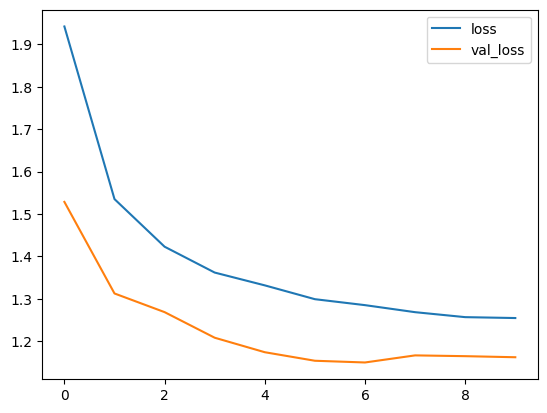

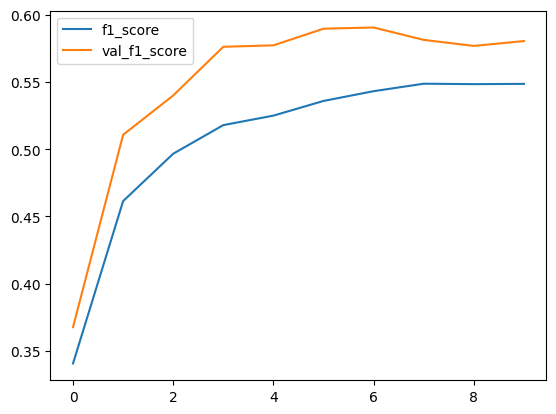

In [165]:
hist = pd.DataFrame(model_6_history.history).reset_index(drop=True)
hist.columns = hist.columns.to_series().apply(lambda x: str(x).replace("_1", ""))
hist['f1_score'] = hist.apply(lambda row: calculate_f1(row["precision"], row["recall"]), axis=1)
hist['val_f1_score'] = hist.apply(lambda row: calculate_f1(row["val_precision"], row["val_recall"]), axis=1)
hist[["loss", "val_loss"]].plot()
plt.show() 
hist[["f1_score", "val_f1_score"]].plot()
plt.show()

### Model 6 fine tune 

In [167]:
model_6.layers[2].trainable = False 

for layer in model_6.layers[2].layers[-15:]:
    if not isinstance(layer, layers.BatchNormalization):
        layer.trainable = True

model_6.compile(loss='categorical_crossentropy', 
              optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), 
              metrics=[
                  tf.keras.metrics.Recall(name="recall"), 
                  tf.keras.metrics.Precision(name="precision")]) 

In [168]:
model_6_history_fine = model_6.fit(train_data64, 
                                epochs=20,
                                initial_epoch=10, 
                                validation_data=val_data64, 
                                validation_steps= len(val_data64), 
                                callbacks=[checkpoint_callback]) 

Epoch 11/20
268/268 [==============================] - 2155s 8s/step - loss: 1.2246 - recall: 0.4323 - precision: 0.7619 - val_loss: 1.1336 - val_recall: 0.4694 - val_precision: 0.8046
Epoch 12/20
268/268 [==============================] - 2135s 8s/step - loss: 1.2016 - recall: 0.4424 - precision: 0.7648 - val_loss: 1.1202 - val_recall: 0.4804 - val_precision: 0.7995
Epoch 13/20
268/268 [==============================] - 2082s 8s/step - loss: 1.1984 - recall: 0.4472 - precision: 0.7637 - val_loss: 1.1177 - val_recall: 0.4800 - val_precision: 0.8043
Epoch 14/20
268/268 [==============================] - 2119s 8s/step - loss: 1.2070 - recall: 0.4492 - precision: 0.7677 - val_loss: 1.1126 - val_recall: 0.4853 - val_precision: 0.7960
Epoch 15/20
268/268 [==============================] - 2104s 8s/step - loss: 1.1989 - recall: 0.4514 - precision: 0.7648 - val_loss: 1.1092 - val_recall: 0.4855 - val_precision: 0.8007
Epoch 16/20
268/268 [==============================] - 2102s 8s/step - loss

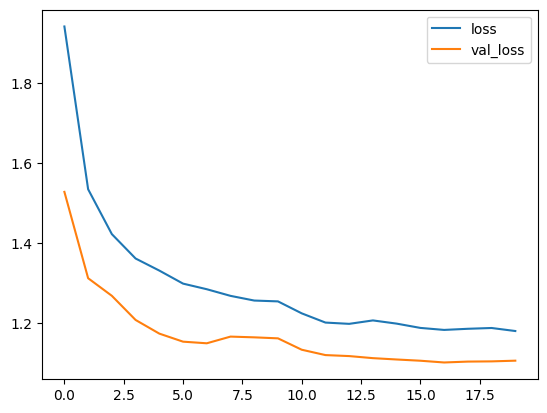

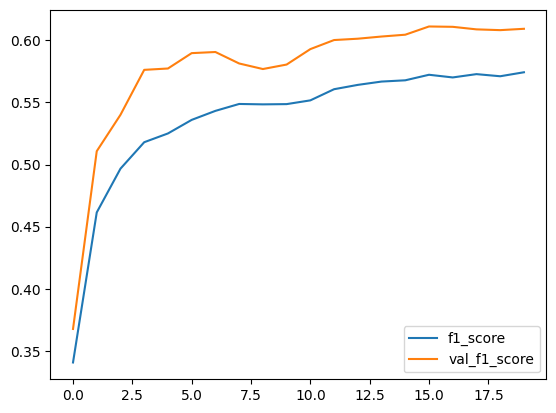

In [171]:
hist = pd.concat([pd.DataFrame(model_6_history.history), pd.DataFrame(model_6_history_fine.history)]).reset_index(drop=True)
hist.columns = hist.columns.to_series().apply(lambda x: str(x).replace("_1", ""))
hist['f1_score'] = hist.apply(lambda row: calculate_f1(row["precision"], row["recall"]), axis=1)
hist['val_f1_score'] = hist.apply(lambda row: calculate_f1(row["val_precision"], row["val_recall"]), axis=1)
hist[["loss", "val_loss"]].plot()
plt.show() 
hist[["f1_score", "val_f1_score"]].plot()
plt.show()

In [172]:
model_6.layers[2].trainable = False 

for layer in model_6.layers[2].layers[-20:]:
    if not isinstance(layer, layers.BatchNormalization):
        layer.trainable = True

model_6.compile(loss='categorical_crossentropy', 
              optimizer=tf.keras.optimizers.Adam(), 
              metrics=[
                  tf.keras.metrics.Recall(name="recall"), 
                  tf.keras.metrics.Precision(name="precision")]) 


In [173]:
model_6_history_fine2 = model_6.fit(train_data64, 
                                epochs=30,
                                initial_epoch=20, 
                                validation_data=val_data64, 
                                validation_steps= len(val_data64), 
                                callbacks=[checkpoint_callback]) 

Epoch 21/30
268/268 [==============================] - 2290s 8s/step - loss: 1.2325 - recall: 0.4496 - precision: 0.7540 - val_loss: 1.1524 - val_recall: 0.4657 - val_precision: 0.7911
Epoch 22/30
268/268 [==============================] - 2206s 8s/step - loss: 1.2301 - recall: 0.4422 - precision: 0.7547 - val_loss: 1.1284 - val_recall: 0.4848 - val_precision: 0.7859
Epoch 23/30
268/268 [==============================] - 2221s 8s/step - loss: 1.2140 - recall: 0.4490 - precision: 0.7609 - val_loss: 1.1118 - val_recall: 0.5102 - val_precision: 0.7860
Epoch 24/30
268/268 [==============================] - 2180s 8s/step - loss: 1.2175 - recall: 0.4558 - precision: 0.7579 - val_loss: 1.1212 - val_recall: 0.4998 - val_precision: 0.7772
Epoch 25/30
268/268 [==============================] - 2184s 8s/step - loss: 1.2023 - recall: 0.4558 - precision: 0.7595 - val_loss: 1.1113 - val_recall: 0.4981 - val_precision: 0.7846
Epoch 26/30
268/268 [==============================] - 2182s 8s/step - loss

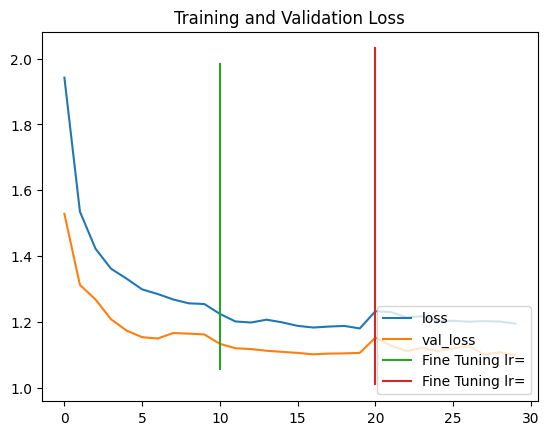

Text(0.5, 1.0, 'Training and Validation F1-Score')

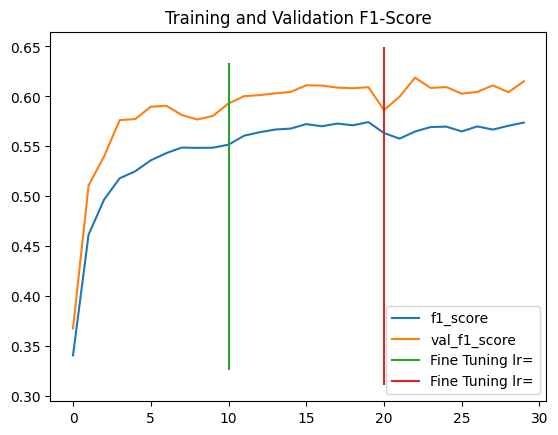

In [187]:
hist = pd.concat([pd.DataFrame(model_6_history.history), 
                  pd.DataFrame(model_6_history_fine.history), 
                  pd.DataFrame(model_6_history_fine2.history)
                ]).reset_index(drop=True)

hist.columns = hist.columns.to_series().apply(lambda x: str(x).replace("_1", ""))
hist['f1_score'] = hist.apply(lambda row: calculate_f1(row["precision"], row["recall"]), axis=1)
hist['val_f1_score'] = hist.apply(lambda row: calculate_f1(row["val_precision"], row["val_recall"]), axis=1)

hist[["loss", "val_loss"]].plot()
plt.plot([10, 10], plt.ylim(), label='Fine Tuning lr=') 
plt.plot([20, 20], plt.ylim(), label='Fine Tuning lr=') 

plt.legend(loc='lower right')
plt.title('Training and Validation Loss')
plt.show() 

hist[["f1_score", "val_f1_score"]].plot()
plt.plot([10, 10], plt.ylim(), label='Fine Tuning lr=') 
plt.plot([20, 20], plt.ylim(), label='Fine Tuning lr=') 
plt.legend(loc='lower right')
plt.title('Training and Validation F1-Score')


In [192]:
np.array([l.trainable for l in model_6.layers[2].layers]).astype("int").sum()

15

In [195]:
model_6.layers[2].trainable = False 

for layer in model_6.layers[2].layers[-25:]:
    if not isinstance(layer, layers.BatchNormalization):
        layer.trainable = True

model_6.compile(loss='categorical_crossentropy', 
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), 
              metrics=[
                  tf.keras.metrics.Recall(name="recall"), 
                  tf.keras.metrics.Precision(name="precision")]) 


In [196]:
np.array([l.trainable for l in model_6.layers[2].layers]).astype("int").sum()

20

In [197]:
model_6_history_fine3= model_6.fit(train_data64, 
                                epochs=40,
                                initial_epoch=30, 
                                validation_data=val_data64, 
                                validation_steps= len(val_data64), 
                                callbacks=[checkpoint_callback]) 

Epoch 31/40


268/268 [==============================] - 1680s 6s/step - loss: 1.5879 - recall: 0.3415 - precision: 0.6794 - val_loss: 1.4889 - val_recall: 0.3883 - val_precision: 0.6974
Epoch 32/40
268/268 [==============================] - 1644s 6s/step - loss: 1.5281 - recall: 0.3558 - precision: 0.7029 - val_loss: 1.3796 - val_recall: 0.4315 - val_precision: 0.7157
Epoch 33/40
268/268 [==============================] - 1632s 6s/step - loss: 1.5067 - recall: 0.3594 - precision: 0.7017 - val_loss: 1.3427 - val_recall: 0.4243 - val_precision: 0.7426
Epoch 34/40
268/268 [==============================] - 1777s 7s/step - loss: 1.4815 - recall: 0.3712 - precision: 0.7078 - val_loss: 1.3391 - val_recall: 0.4103 - val_precision: 0.7448
Epoch 35/40
268/268 [==============================] - 2228s 8s/step - loss: 1.4667 - recall: 0.3741 - precision: 0.7093 - val_loss: 1.3274 - val_recall: 0.4079 - val_precision: 0.7644
Epoch 36/40
268/268 [==============================] - 2248s 8s/step - loss: 1.4589 - r

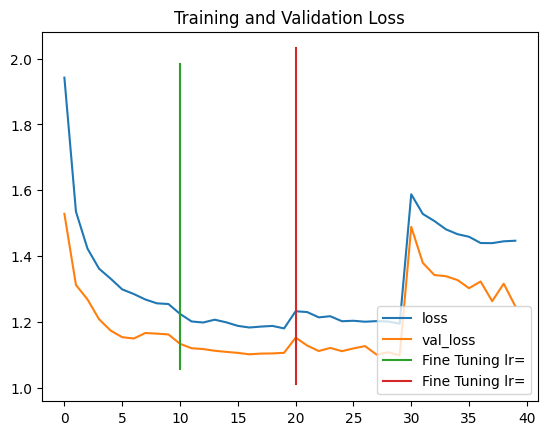

Text(0.5, 1.0, 'Training and Validation F1-Score')

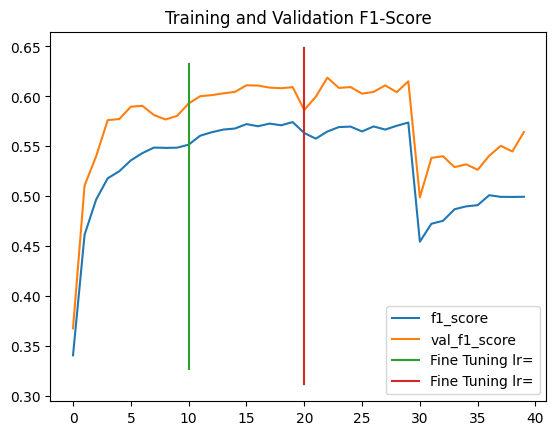

In [198]:
hist = pd.concat([pd.DataFrame(model_6_history.history), 
                  pd.DataFrame(model_6_history_fine.history), 
                  pd.DataFrame(model_6_history_fine2.history), 
                  pd.DataFrame(model_6_history_fine3.history), 
                ]).reset_index(drop=True)

hist.columns = hist.columns.to_series().apply(lambda x: str(x).replace("_1", ""))
hist['f1_score'] = hist.apply(lambda row: calculate_f1(row["precision"], row["recall"]), axis=1)
hist['val_f1_score'] = hist.apply(lambda row: calculate_f1(row["val_precision"], row["val_recall"]), axis=1)

hist[["loss", "val_loss"]].plot()
plt.plot([10, 10], plt.ylim(), label='Fine Tuning lr=') 
plt.plot([20, 20], plt.ylim(), label='Fine Tuning lr=') 

plt.legend(loc='lower right')
plt.title('Training and Validation Loss')
plt.show() 

hist[["f1_score", "val_f1_score"]].plot()
plt.plot([10, 10], plt.ylim(), label='Fine Tuning lr=') 
plt.plot([20, 20], plt.ylim(), label='Fine Tuning lr=') 
plt.legend(loc='lower right')
plt.title('Training and Validation F1-Score')


In [ ]:
model_6_history_fine3= model_6.fit(train_data64, 
                                epochs=80,
                                initial_epoch=40, 
                                validation_data=val_data64, 
                                validation_steps= len(val_data64), 
                                callbacks=[checkpoint_callback]) 

# epoch 78: loss: 1.4235 - recall: 0.3991 - precision: 0.7301 - val_loss: 1.3535 - val_recall: 0.4384 - val_precision: 0.7421

# Model 7: Base Resnet

In [200]:
base_resnet = tf.keras.applications.ResNet50V2(
    include_top=False, 
    weights="imagenet")

base_resnet.trainable = False 

In [208]:
def model_7(training = False): 
    inputs = layers.Input(shape=(224, 224, 3), name="input_shape") 
    x = tf.cast(inputs, tf.float32)
    x = tf.keras.applications.resnet_v2.preprocess_input(x) 
    x = base_resnet(x, training=training) 
    x = layers.GlobalAveragePooling2D(name="global_average_pooling")(x) 
    outputs = layers.Dense(len(train["class"].unique()), activation='softmax', name='output')(x)
    return tf.keras.Model(inputs, outputs) 

In [210]:
model_7 = model_7()

checkpoint_path = './checkpoints/model_7/checkpoint-{epoch:01d}.ckpt'
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights_only=True, 
                                                         monitor='val_loss', 
                                                         save_best_only=False) 
model_7.compile(loss='categorical_crossentropy', 
              optimizer=tf.keras.optimizers.Adam(), 
              metrics=[
                  tf.keras.metrics.Recall(name="recall"), 
                  tf.keras.metrics.Precision(name="precision")]) 

model_7_history = model_7.fit(train_data64, 
                                epochs=10, 
                                validation_data=val_data64, 
                                validation_steps= len(val_data64), 
                                callbacks=[checkpoint_callback]) 

Epoch 1/10
  5/268 [..............................] - ETA: 1:30:16 - loss: 2.9949 - recall: 0.0000e+00 - precision: 0.0000e+00